In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time

import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

%matplotlib inline
plt.style.use('seaborn-white')

/home/hhp468/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Linear Model Selection and Regularization

As we discussed before, the linear model is typically fitted using least squares. Today, we will discuss some ways in which the simple linear model can be improved, by replacing plain least squares fitting with some alternative fitting procedures. Why might we want to use another fitting procedure instead of least squares? As we will see, alternative fitting procedures can yield better prediction accuracy and model interpretability.
* **Prediction Accuracy**: Provided that the true relationship between the response and the predictors is approximately linear, the least squares estimates will have low bias. If n, the number of observations, is much larger than p, the number of variables—then the least squares estimates tend to also have low variance, and hence will perform well on test observations. However, if n is not much larger than p, then there can be a lot of variability in the least squares fit, resulting in overfitting and consequently poor predictions on future observations not used in model training. And if p > n, then there is no longer a unique least squares coefficient estimate: the variance is infinite so the method cannot be used at all. By using *shrinkage method*, we can often substantially reduce the variance at the cost of a negligible increase in bias
+ **Model Interpretability**: It is often the case that some or many of the variables used in a multiple regression model are in fact not associated with the response. Including such irrelevant variables leads to unnecessary complexity in the resulting model. By removing these variables—that is, by setting the corresponding coefficient estimatesto zero—we can obtain a model that is more easily interpreted.

In this chapter, we discuss two important classes of methods:

* **Subset Selection**:This approach involves identifying a subset of the p predictors that we believe to be related to the response. We then fit a model using least squares on the reduced set of variables.
+ **Shrinkage**: This approach involves fitting a model involving all p predictors. However, the estimated coefficients are shrunken towards zero relative to the least squares estimates. This *shrinkage* (also known as *regularization*) has the effect of reducing variance. Depending on what type of shrinkage is performed, some of the coefficients may be estimated to be exactly zero. Hence, shrinkage methods can also perform variable selection.

## Subset Selection
In this section we consider some methods for selecting subsets of predictors. These include best subset and stepwise model selection procedures.



### Best Subset Selection
To perform *best subset selection*, we fit a separate least squares regression for each possible combination of the p predictors. That is, we fit all p models that contain exactly one predictor, all p(p−1)/2 models that contain
exactly two predictors, and so forth. We then look at all of the resulting models, with the goal of identifying the one that is best.

The problem of selecting the best model from among the $2^p$ possibilities considered by best subset selection is not trivial. This is usually broken up into two stages, as described in following Algorithm.

![alt text](BSS1.png)

In the Algorithm, Step 2 identifies the best model (on the training data) for each subset size, in order to reduce the problem from one of $2^p$ possible models to one of $p + 1$ possible models. Now in order to select a single best model, we must simply choose among these $p + 1$ options. This task must be performed with care, because the RSS of these $p + 1$ models decreases monotonically, and the $R^2$ increases monotonically, as the number of features included in the models increases. Therefore, if we use these statistics to select the best model, then we will always end up with a model involving all of the variables. The problem is that a low RSS or a high $R^2$ indicates a model with a low training error, whereas we wish to choose a model that has a low test error. Therefore, in Step 3, we use cross-validated prediction error, $C_p$(AIC), BIC, or adjusted $R^2$ in order to select among $M_0, M_1, . . . , M_p$.

### $C_p$, AIC, BIC, and Adjusted $R^2$
In order to select the best model with respect to test error, we need to estimate this test error. There are two common approaches:
* We can indirectly estimate test error by making an adjustment to the training error to account for the bias due to overfitting. We will discuss in following section.
+ We can directly estimate the test error, using either a validation set approach or a cross-validation approach. (As homework)

A number of techniques for adjusting the training error for the model size are available. These approaches can be used to select among a set of models with different numbers of variables. We now consider four such approaches: $C_p$, *Akaike information criterion* (AIC), *Bayesian information criterion* (BIC), and adjusted $R^2$.

$C_p$: For a fitted least squares model containing d predictors, the $C_p$ estimate of test MSE is computed using the equation:
$$C_p=\frac{1}{n}(RSS+2d\hat \sigma)$$
where $\hat \sigma$ is an estimate of the variance of the error associated with each response measurement. Though it is beyond the scope of this course, one can show that if $\hat \sigma$ is an unbiased estimate of $\sigma$ of the model, then $C_p$ is an unbiased estimate of test MSE.

**AIC**:The AIC criterion is defined for a large class of models fit by maximum likelihood. In the case of the model with Gaussian errors, maximum likelihood and least squares are the same thing. In this case AIC is given by
$$AIC=\frac{1}{n\hat \sigma}(RSS+2d\hat \sigma)$$

**BIC**: BIC is derived from a Bayesian point of view, but ends up looking similar to C_p (and AIC) as well. For the least squares model with d predictors, the BIC is, up to irrelevant constants, given by:
$$BIC=\frac{1}{n\hat \sigma}(RSS+log(n)d\hat \sigma)$$

**Adjusted** $R^2$ statistic is calculated as:
$$Adjusted R^2= 1 - \frac{RSS/(n-d-1)}{TSS/(n-1)}$$
where total sum of squares (TSS) is:
$$TSS=\sum (y_i-\bar y)^2$$
Unlike $C_p$, AIC, and BIC, for which a small value indicates a model with a low test error, a large value of adjusted R^2 indicates a model with a small test error.

### Hitters data
Here we apply the best subset selection approach to the Hitters data. We wish to predict a baseball player’s Salary on the basis of various statistics associated with performance in the previous year. Let's take a quick look:

In [2]:
df = pd.read_csv('Hitters.csv')
df.head()

Player  AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  \
0     -Andy Allanson    293    66      1    30   29     14      1     293   
1        -Alan Ashby    315    81      7    24   38     39     14    3449   
2       -Alvin Davis    479   130     18    66   72     76      3    1624   
3      -Andre Dawson    496   141     20    65   78     37     11    5628   
4  -Andres Galarraga    321    87     10    39   42     30      2     396   

   CHits    ...      CRuns  CRBI  CWalks  League Division PutOuts  Assists  \
0     66    ...         30    29      14       A        E     446       33   
1    835    ...        321   414     375       N        W     632       43   
2    457    ...        224   266     263       A        W     880       82   
3   1575    ...        828   838     354       N        E     200       11   
4    101    ...         48    46      33       N        E     805       40   

   Errors  Salary  NewLeague  
0      20     NaN          A  
1      10   475.0          N  
2      14   480.0          A  
3       3   500.0          N  
4       4    91.5          N  

[5 rows x 21 columns]

In [3]:
print(df["Salary"].isnull().sum())

59


First of all, we note that the ${\tt Salary}$ variable is missing for some of the players. The ${\tt isnull()}$ function can be used to identify the missing observations. It returns a vector of the same length as the input vector, with a ${\tt TRUE}$ value for any elements that are missing, and a ${\tt FALSE}$ value for non-missing elements. The ${\tt sum()}$ function can then be used to count all of the missing elements. The ${\tt dropna()}$ function removes all of the rows that have missing values in any variable:

In [10]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print(df.shape)

# Drop any rows the contain missing values, along with the player names
df = df.dropna().drop('Player', axis=1)

# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print(df.shape)

# One last check: should return 0
print(df["Salary"].isnull().sum())

(322, 21)
(263, 20)
0


In [11]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

We can perform best subset selection by identifying the best model that contains a given number of predictors, where **best** is quantified using RSS. We'll define a helper function to outputs the best set of variables for
each model size:

In [49]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS,"model2":model}
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].idxmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [7]:
# Could take quite awhile to complete...

models = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,20):
    models.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 1 predictors in 0.9306437969207764 seconds.
Processed  171 models on 2 predictors in 0.31612133979797363 seconds.
Processed  969 models on 3 predictors in 1.5553178787231445 seconds.
Processed  3876 models on 4 predictors in 6.499192953109741 seconds.
Processed  11628 models on 5 predictors in 20.301698684692383 seconds.
Processed  27132 models on 6 predictors in 50.248169898986816 seconds.
Processed  50388 models on 7 predictors in 95.02524733543396 seconds.
Processed  75582 models on 8 predictors in 149.94655585289001 seconds.
Processed  92378 models on 9 predictors in 189.3255386352539 seconds.
Processed  92378 models on 10 predictors in 192.09182500839233 seconds.
Processed  75582 models on 11 predictors in 158.0542676448822 seconds.
Processed  50388 models on 12 predictors in 106.19899249076843 seconds.
Processed  27132 models on 13 predictors in 57.75194835662842 seconds.
Processed  11628 models on 14 predictors in 25.84611678123474 seconds.
Processed  387

Rather than letting the results of our call to the ${\tt summary()}$ function print to the screen, we can access just the parts we need using the model's attributes. For example, if we want the $R^2$ value. In addition to the verbose output we get when we print the summary to the screen, fitting the ${\tt OLM}$ also produced many other useful statistics such as adjusted $R^2$, AIC, and BIC. We can examine these to try to select the best overall model. Let's start by looking at $R^2$ across all our models:

In [8]:
models.loc[2, "model"].rsquared
# Gets the second element from each row ('model') and pulls out its rsquared attribute
models.apply(lambda row: row[1].rsquared, axis=1)

1     0.664637
2     0.761495
3     0.771757
4     0.782885
5     0.789008
6     0.795140
7     0.797728
8     0.802259
9     0.804453
10    0.806490
11    0.808011
12    0.808599
13    0.809034
14    0.809252
15    0.809408
16    0.809516
17    0.809612
18    0.809686
19    0.809695
dtype: float64

As expected, the $R^2$ statistic increases monotonically as more variables are included.

Plotting RSS, adjusted $R^2$, AIC, and BIC for all of the models at once will
help us decide which model to select. Note the ${\tt type="l"}$ option tells ${\tt R}$ to
connect the plotted points with lines:

Text(0,0.5,'BIC')

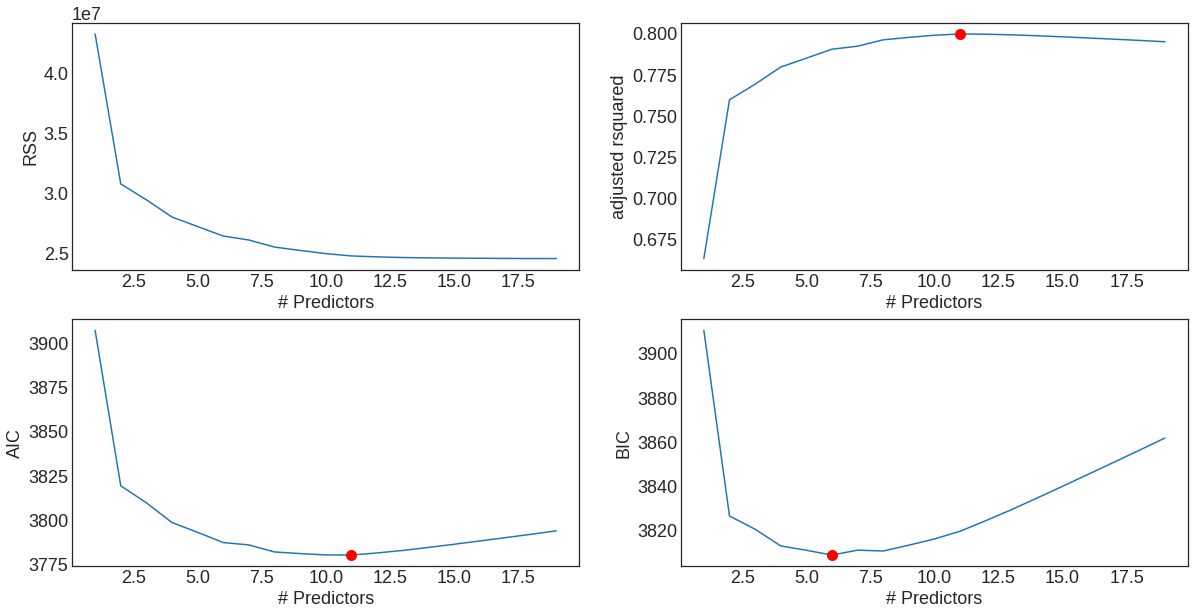

In [9]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.idxmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.idxmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.idxmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

Recall that in the second step of our selection process, we narrowed the field down to just one model on any $k<=p$ predictors. We see that according to BIC, the best performer is the model with 6 variables. According to AIC and adjusted $R^2$ something a bit more complex (11 variables) might be better. Again, no one measure is going to give us an entirely accurate picture... but they all agree that a model with 5 or fewer predictors is insufficient.

In [10]:
print(models.loc[6, "model"].params)
print(models.loc[11, "model"].params)

AtBat          -1.548829
Hits            7.019007
Walks           3.751336
CRBI            0.654416
PutOuts         0.270287
Division_W   -104.451269
dtype: float64
AtBat         -1.699252
Hits           6.295602
Walks          5.477680
CAtBat        -0.118611
CRuns          1.326832
CRBI           0.727161
CWalks        -0.745003
PutOuts        0.289985
Assists        0.221927
League_N      69.576524
Division_W   -90.259640
dtype: float64


### Forward and Backward Stepwise Selection
We can also use a similar approach to perform forward stepwise
or backward stepwise selection, using a slight modification of the functions we defined above:

![alt text](BSS2.png)
![alt text](BSS3.png)

In [50]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].idxmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [56]:
models2 = pd.DataFrame(columns=["RSS", "model","model2"])

tic = time.time()
predictors = []

for i in range(1,20):    
    models2.loc[i] = forward(predictors)
    predictors = models2.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 1 predictors in 0.04791092872619629 seconds.
Processed  18 models on 2 predictors in 0.028485774993896484 seconds.
Processed  17 models on 3 predictors in 0.02590632438659668 seconds.
Processed  16 models on 4 predictors in 0.027379989624023438 seconds.
Processed  15 models on 5 predictors in 0.026108741760253906 seconds.
Processed  14 models on 6 predictors in 0.02481532096862793 seconds.
Processed  13 models on 7 predictors in 0.023260831832885742 seconds.
Processed  12 models on 8 predictors in 0.021862506866455078 seconds.
Processed  11 models on 9 predictors in 0.022260427474975586 seconds.
Processed  10 models on 10 predictors in 0.02281665802001953 seconds.
Processed  9 models on 11 predictors in 0.017476320266723633 seconds.
Processed  8 models on 12 predictors in 0.015852928161621094 seconds.
Processed  7 models on 13 predictors in 0.01428675651550293 seconds.
Processed  6 models on 14 predictors in 0.012967586517333984 seconds.
Processed  5 models on 1

In [60]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm
 
class statsmodel(BaseEstimator, RegressorMixin):
    def __init__(self, sm_class, formula):
        self.sm_class = sm_class
        self.formula = formula
        self.model = None
        self.result = None
 
    def fit(self,data,dummy):
        self.model = self.sm_class(self.formula,data)
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)

In [59]:
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
folds= 10
err=[]
for model in models2['model2']:
    kf_10 = KFold(n_splits=folds)
    err.append(cross_val_score(model, X, y, cv=kf_10, scoring='neg_mean_squared_error').mean())
print(err)

TypeError: Cannot clone object '<statsmodels.regression.linear_model.OLS object at 0x7ff6d806b320>' (type <class 'statsmodels.regression.linear_model.OLS'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.

Text(0,0.5,'BIC')

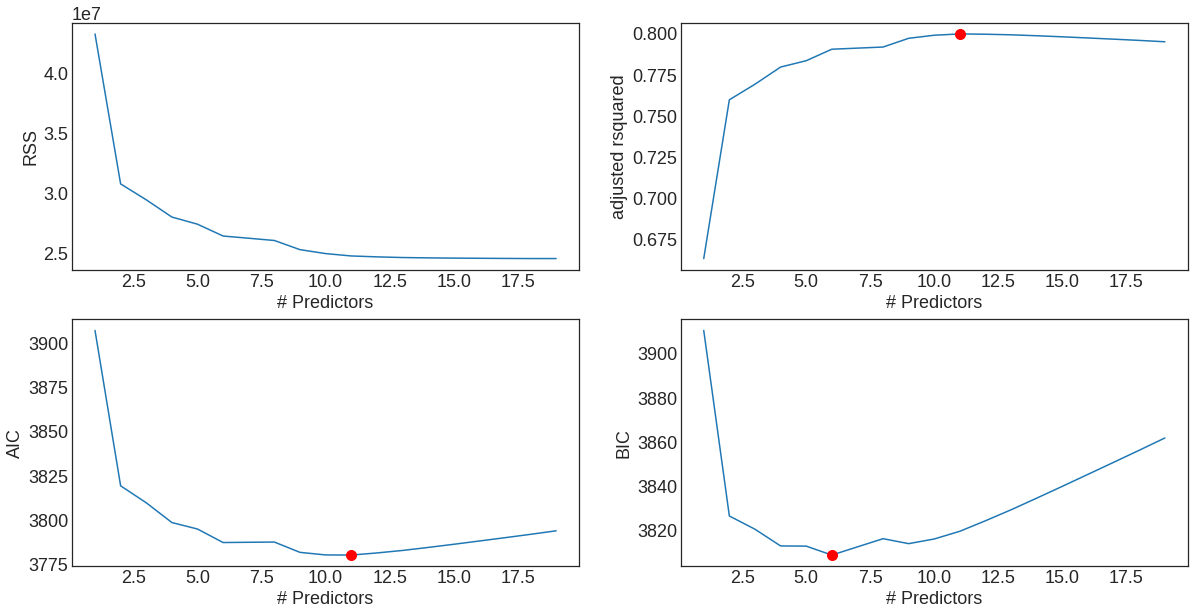

In [21]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models2["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models2.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.idxmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models2.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.idxmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models2.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.idxmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [14]:
print(models.loc[6, "model"].params)
print(models.loc[11, "model"].params)

AtBat          -1.548829
Hits            7.019007
Walks           3.751336
CRBI            0.654416
PutOuts         0.270287
Division_W   -104.451269
dtype: float64
AtBat         -1.699252
Hits           6.295602
Walks          5.477680
CAtBat        -0.118611
CRuns          1.326832
CRBI           0.727161
CWalks        -0.745003
PutOuts        0.289985
Assists        0.221927
League_N      69.576524
Division_W   -90.259640
dtype: float64


In [15]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].idxmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [16]:
models3 = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models3.loc[len(predictors)-1] = backward(predictors)
    predictors = models3.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 18 predictors in 0.05358099937438965 seconds.
Processed  18 models on 17 predictors in 0.041501760482788086 seconds.
Processed  17 models on 16 predictors in 0.036997079849243164 seconds.
Processed  16 models on 15 predictors in 0.03451657295227051 seconds.
Processed  15 models on 14 predictors in 0.03199934959411621 seconds.
Processed  14 models on 13 predictors in 0.029697179794311523 seconds.
Processed  13 models on 12 predictors in 0.028448104858398438 seconds.
Processed  12 models on 11 predictors in 0.030773401260375977 seconds.
Processed  11 models on 10 predictors in 0.03079700469970703 seconds.
Processed  10 models on 9 predictors in 0.022957563400268555 seconds.
Processed  9 models on 8 predictors in 0.018807649612426758 seconds.
Processed  8 models on 7 predictors in 0.016596555709838867 seconds.
Processed  7 models on 6 predictors in 0.014486074447631836 seconds.
Processed  6 models on 5 predictors in 0.012571573257446289 seconds.
Processed  5 models

Text(0,0.5,'BIC')

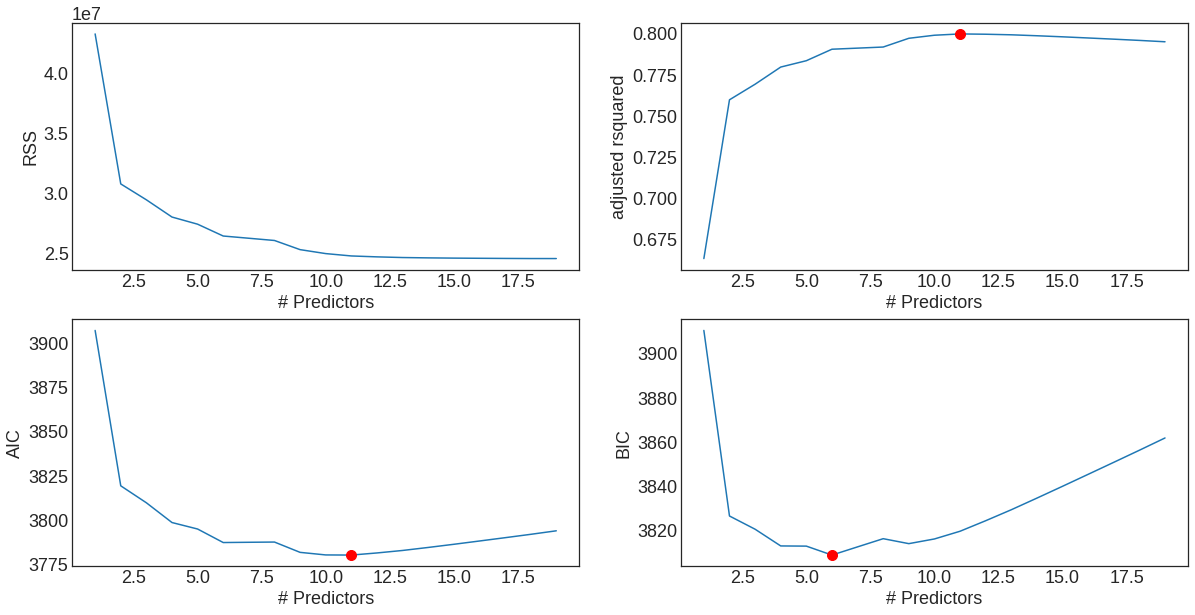

In [17]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models2["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models2.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.idxmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models2.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.idxmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models2.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.idxmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [18]:
print(models.loc[6, "model"].params)
print(models.loc[11, "model"].params)

AtBat          -1.548829
Hits            7.019007
Walks           3.751336
CRBI            0.654416
PutOuts         0.270287
Division_W   -104.451269
dtype: float64
AtBat         -1.699252
Hits           6.295602
Walks          5.477680
CAtBat        -0.118611
CRuns          1.326832
CRBI           0.727161
CWalks        -0.745003
PutOuts        0.289985
Assists        0.221927
League_N      69.576524
Division_W   -90.259640
dtype: float64


It runs a lot faster!!! And give same result!.